# Laboratorio 8: *Puesta en producción de un modelo de ML*

In [165]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import de yprofiler
from ydata_profiling import ProfileReport

import seaborn as sns
import math

## Parte 1: Selección de Modelos

### 1.1. Conjunto de datos
Se proporcionará un conjunto de datos sobre alquileres de viviendas en Brasil en el 2020.
Este dataset incluye las siguientes características:
- city: ciudad de ubicación
- area: área en metros cuadrados
- rooms: número de habitaciones
- bathroom: número de baños
- parking spaces: número de espacios para parqueo
- floor: nivel o piso en el que se encuentra
- animal: si se permiten animales o no
- furniture: si está amueblado o no
- hoa (R$): impuesto de la Asociación de Dueños, en Reales Brasileños
- rent amount (R$): mensualidad
- property tax (R$): impuesto sobre bienes inmuebles
- fire insurance (R$): seguro contra incendios
- total (R$): total de la renta mensual

In [166]:
# carga de archivo a datarame
df = pd.read_csv('houses_to_rent_v2.csv')
print(df.shape)
df.head()


(10692, 13)


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


### 1.2. Proceso de selección de modelo

#### a) Exploración de datos (10 puntos):
 - Realice un análisis exploratorio detallado del conjunto de datos.
 - Identifique patrones, correlaciones y posibles outliers.
 - Visualice la distribución de las variables clave.


In [167]:
# Analsis exploratorio preliminar usando ydata profiling
# profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
# profile.to_widgets()

El análisis de correlación muestra que varias variables presentan relaciones significativas entre sí. Por ejemplo, `area` está altamente correlacionada con `bathroom` y otras seis variables, indicando que el tamaño de la propiedad tiende a aumentar con el número de baños y otros factores relacionados. Otras variables, como `total (R$)`, también muestran alta correlación con hasta siete atributos, lo que sugiere una fuerte relación entre el costo total y factores como `hoa (R$)`, `rent amount (R$)`, y `property tax (R$)`.

El mapa de calor confirma estas observaciones al destacar las relaciones con tonalidades más oscuras para las correlaciones fuertes. Variables como `area`, `bathroom`, y `rooms` muestran alta correlación entre sí, lo que refleja una tendencia lógica en la que propiedades más grandes suelen tener más habitaciones y baños. Por otro lado, algunas variables presentan correlaciones más débiles, indicadas por colores más cercanos al blanco, lo que indica relaciones menos significativas entre estos atributos.

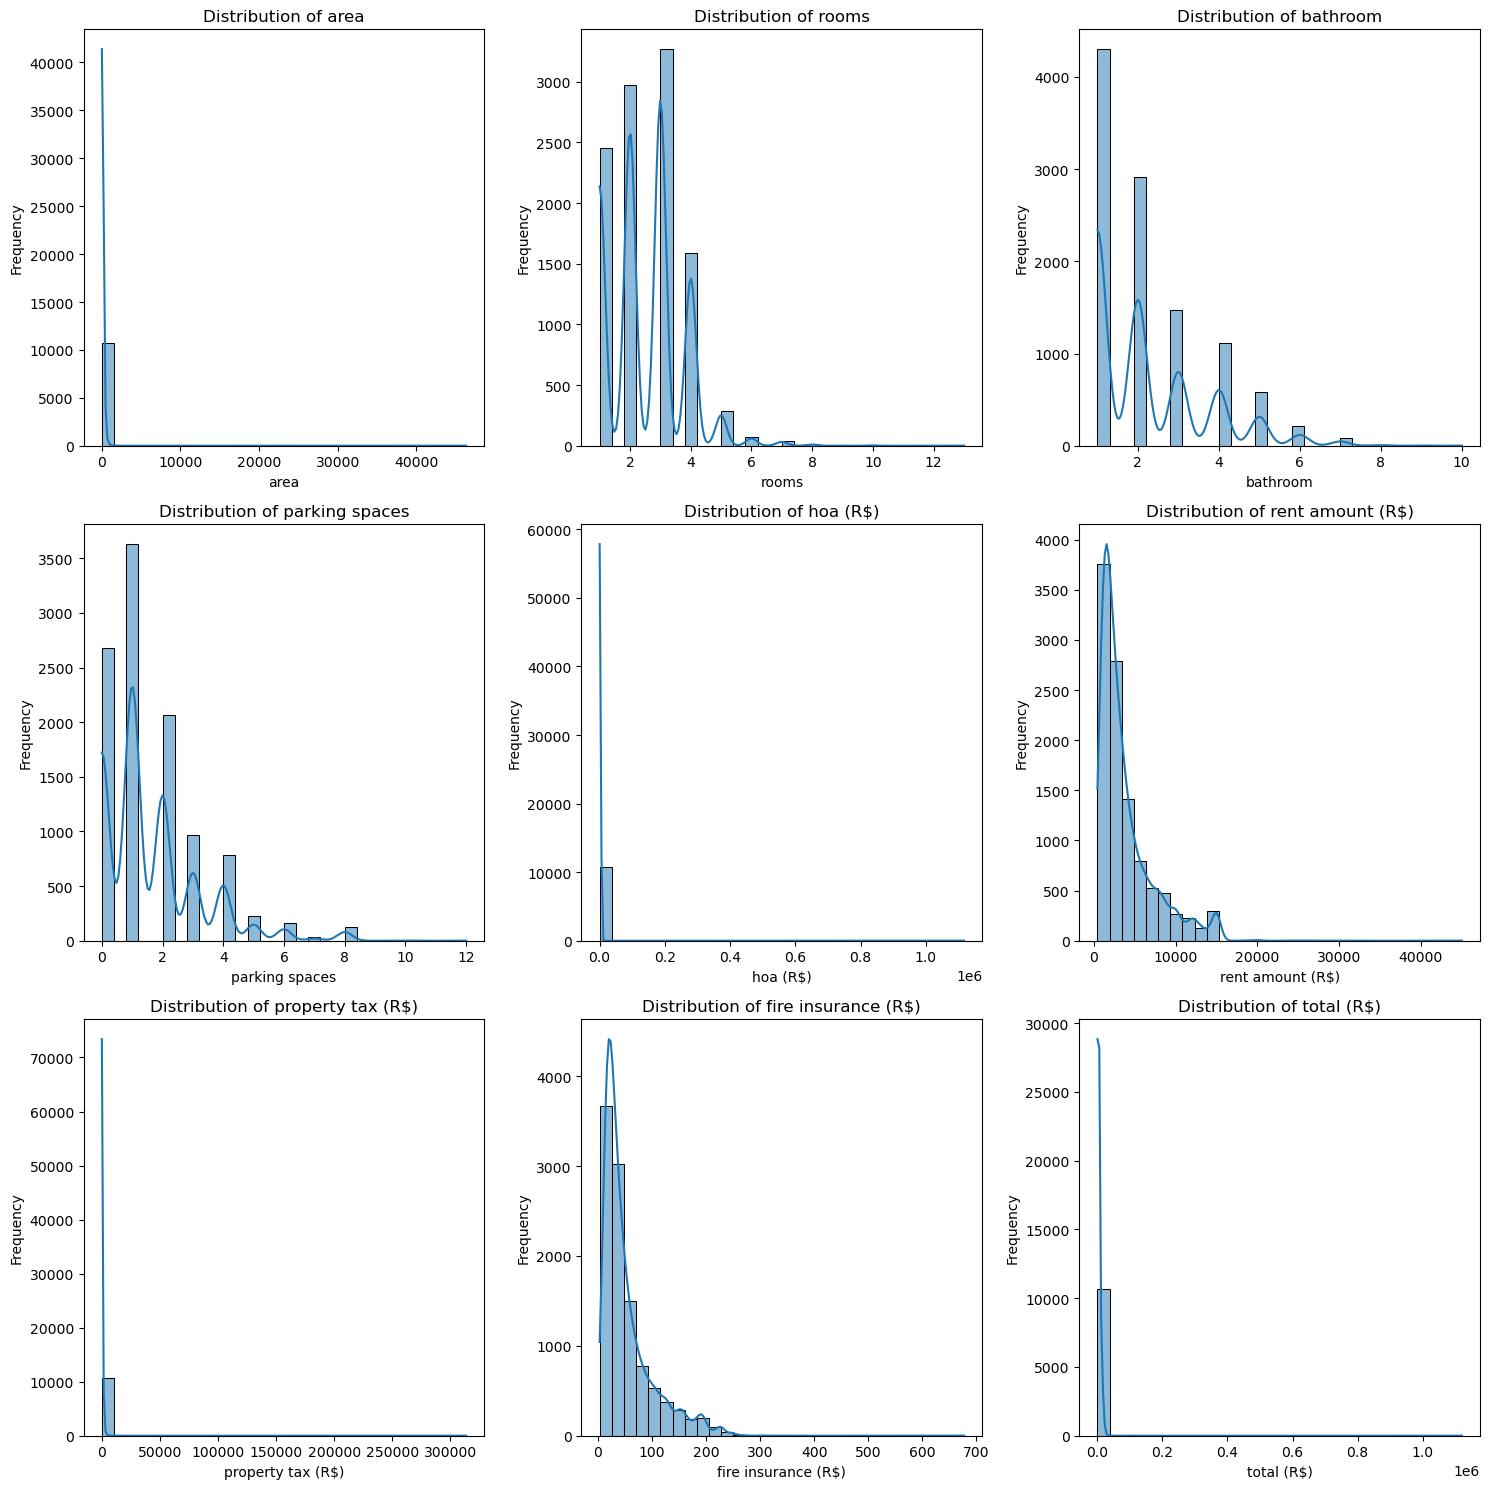

In [168]:
# Suponiendo que tu DataFrame se llama df y contiene variables numéricas
num_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Configuración de la cuadrícula: ajustar filas y columnas según el número de variables
num_vars = len(num_columns)
cols = 3  # Puedes ajustar el número de columnas que desees
rows = math.ceil(num_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

# Crear gráficos para cada variable
for i, column in enumerate(num_columns):
    row = i // cols
    col = i % cols
    sns.histplot(df[column], kde=True, ax=axes[row, col], bins=30)
    axes[row, col].set_title(f'Distribution of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

# Eliminar gráficos vacíos si hay menos variables que espacios en la cuadrícula
for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

#### b) Preprocesamiento y limpieza de datos (10 puntos):
 - Maneje los valores faltantes y outliers de manera apropiada.
 - Realice la codificación de variables categóricas.
 - Normalice o estandarice las variables numéricas según sea necesario.

In [169]:
# buscar en todas las celdas las filas que contengan "-". 
# Si encuentra alguna, la reemplaza por NaN. 
# Si no encuentra ninguna, no hace nada.

for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].apply(lambda x: 0 if '-' in str(x) else x)

df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020


In [170]:
# Identifica valores faltantes en el DataFrame

# Calcular el número de valores faltantes y el porcentaje para cada columna
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Crear un DataFrame para mostrar los resultados de manera organizada
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

# Filtrar solo las columnas con valores faltantes
missing_data = missing_data[missing_data['Missing Values'] > 0]
missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

# Si hay valores faltantes, mostrar el DataFrame con los resultados. Si no, mostrar un mensaje indicando que no hay valores faltantes
if missing_data.empty:
    print('No missing values found in the DataFrame')
else:
    print('Missing values found in the following columns:')
    print(missing_data)

No missing values found in the DataFrame


In [171]:
# Definir un DataFrame para almacenar los outliers y un diccionario para rastrear los eliminados
z_outliers = pd.DataFrame()
removed_rows = []

# Detectar outliers para cada columna numérica usando Z-Score
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    z_scores = stats.zscore(df[column])
    outlier_indices = df[(z_scores > 3) | (z_scores < -3)].index
    z_outliers[column] = df.loc[outlier_indices, column]
    
    # Registrar las filas eliminadas y los valores atípicos detectados
    for index in outlier_indices:
        removed_rows.append((index, column, df.at[index, column]))

# Eliminar filas sin outliers
z_outliers.dropna(how='all', inplace=True)

contador = 0

# Imprimir detalles de los valores atípicos que serán eliminados
for row in removed_rows:
    #print(f"Fila {row[0]} eliminada: {row[1]} tiene un valor atípico de {row[2]}")
    contador += 1

# Eliminar las filas con outliers del DataFrame principal
df_clean = df.drop(z_outliers.index)

print(f"Se eliminaron {contador} filas con outliers")

Se eliminaron 770 filas con outliers


In [172]:
# aplicar one hot encoding a la variable city, animal y furniture
df_clean = pd.get_dummies(df_clean, columns=['city', 'animal', 'furniture'])

# Mostrar las primeras filas del DataFrame limpio
df_clean.head()

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),city_Belo Horizonte,city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo,animal_acept,animal_not acept,furniture_furnished,furniture_not furnished
0,70,2,1,1,7,2065,3300,211,42,5618,False,False,False,False,True,True,False,True,False
1,320,4,4,0,20,1200,4960,1750,63,7973,False,False,False,False,True,True,False,False,True
2,80,1,1,1,6,1000,2800,0,41,3841,False,False,True,False,False,True,False,False,True
3,51,2,1,0,2,270,1112,22,17,1421,False,False,True,False,False,True,False,False,True
4,25,1,1,0,1,0,800,25,11,836,False,False,False,False,True,False,True,False,True


No se requiere de normalizacion para este conjunto de datos, en este punto del preprocesamiento. 

#### c) Entrenamiento y selección de modelos (15 puntos):
 - Implemente al menos tres algoritmos diferentes (por ejemplo, Regresión Lineal, Random Forest, Gradient Boosting).
 - Utilice técnicas de validación cruzada para evaluar el rendimiento de los modelos.
 - Compare los modelos utilizando métricas como RMSE, MAE y R²

In [174]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# importa linear regression, random forest y gradient boosting
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Crear una copia de df_clean
df_comparison = df_clean.copy()

# Definir las características (X) y la variable objetivo (y)
X = df_comparison.drop(columns=['total (R$)'])
y = df_comparison['total (R$)']

# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos a comparar
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Diccionario para almacenar los resultados
results = {}

# Entrenar, predecir y evaluar cada modelo
for name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular las métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    accuracy = model.score(X_test, y_test)
    
    # Guardar los resultados en el diccionario
    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'accuracy': accuracy
    }

# Mostrar los resultados
print("Comparación de Modelos:")
for model_name, metrics in results.items():
    print(f"\nModelo: {model_name}")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"MAE: {metrics['MAE']}")
    print(f"R²: {metrics['R²']}")
    print(f"🡆 Accuracy: {metrics['accuracy']:.2f}")

# Seleccionar el mejor modelo basado en las métricas
best_model = min(results, key=lambda k: (results[k]['RMSE'], results[k]['MAE'], -results[k]['R²']))

print(f"\n⫸ El mejor modelo es: {best_model}")

Comparación de Modelos:

Modelo: Linear Regression
RMSE: 1.1125499910525953
MAE: 0.5518948718541064
R²: 0.999999973418377
🡆 Accuracy: 1.00

Modelo: Random Forest
RMSE: 2217.3268261759185
MAE: 144.04586061739943
R²: 0.8944150913293665
🡆 Accuracy: 0.89

Modelo: Gradient Boosting
RMSE: 1049.6676736992026
MAE: 157.12543468672433
R²: 0.9763382930611232
🡆 Accuracy: 0.98

⫸ El mejor modelo es: Linear Regression


#### d) Interpretación de resultados (5 puntos):
 - Analice la importancia de las características en el modelo seleccionado.
 - Explique las fortalezas y debilidades del modelo elegido.


En la comparación de los tres modelos entrenados (Regresión Lineal, Random Forest, y Gradient Boosting), se observan las siguientes métricas de rendimiento:

1. **Regresión Lineal**:
   - **RMSE**: 1.11, **MAE**: 0.55, **R²**: 0.9999
   - Este modelo muestra el menor error cuadrático medio (RMSE) y error absoluto medio (MAE), indicando que sus predicciones están muy cerca de los valores reales. Además, el R² cercano a 1 (0.9999) sugiere que el modelo explica casi la totalidad de la variabilidad de los datos. Esto sugiere una relación lineal fuerte y bien ajustada.

2. **Random Forest**:
   - **RMSE**: 2217.32, **MAE**: 144.05, **R²**: 0.89
   - Aunque Random Forest es robusto y captura relaciones no lineales, muestra un RMSE y MAE mucho más altos que la Regresión Lineal, y un R² más bajo (0.89), lo que indica que el modelo no se ajusta tan bien a los datos como la regresión lineal. 

3. **Gradient Boosting**:
   - **RMSE**: 1049.67, **MAE**: 157.12, **R²**: 0.976
   - Gradient Boosting tiene un rendimiento intermedio. Aunque su R² es alto (0.976), mostrando que captura la mayor parte de la variabilidad, el RMSE y MAE son significativamente mayores que los de la Regresión Lineal, indicando predicciones menos precisas.

<br>

**Mejor Modelo**: La **Regresión Lineal** es el mejor modelo, ya que presenta los valores más bajos de RMSE y MAE, y un R² muy cercano a 1, lo que sugiere una excelente capacidad predictiva.
   - **Fortalezas**: Captura relaciones lineales de manera eficiente, con resultados precisos y consistentes.
   - **Debilidades de Otros Modelos**: A pesar de la capacidad de Random Forest y Gradient Boosting para manejar relaciones no lineales, en este conjunto de datos parecen no ser necesarios, ya que sus errores son mayores y no aportan mejoras significativas.